### 🛠️ Define Paths and Hyperparameters
Sets file paths and model training hyperparameters.

In [ ]:
# Define dataset paths and training hyperparameters
PH2_DATASET_TEXT_PATH = "/kaggle/input/ph2dataset/PH2Dataset/PH2_dataset.txt"
PH2_DATASET_GENERATED_CSV_PATH = "/kaggle/working/PH2_dataset.csv"
HAM_METADATA_PATH = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
PAD_METADATA_PATH = "/kaggle/input/skin-cancer/metadata.csv"
DARM_METADATA_PATH = "/kaggle/input/derm7pt/release_v0/meta/meta.csv"
BASE_DIR = "/kaggle/input"
FINAL_METADATA_PATH = "/kaggle/working/unified_metadata.csv"
AUGMENTED_DATA_PATH = "/kaggle/working/augmented_data/"
AUGMENTED_METADATA_PATH = "/kaggle/working/augmented_metadata.csv"
TRAIN_METADATA_PATH = "/kaggle/working/train_df.csv"
VAL_METADATA_PATH = "/kaggle/working/validation_df.csv"
TEST_METADATA_PATH = "/kaggle/working/test_df.csv"

BATCH = 32
EPOCH = 160
NUM_WORKER = 4
LR = 3e-3
ETA_MIN = 1e-5
T_MAX = 120
WEIGHT_DECAY = 1e-5

### 📁 Setup Directory
Cleans and prepares the directory for storing augmented data.

In [2]:
# Clean up and create the augmented data directory
!rm -rf /kaggle/working/augmented_data
!mkdir /kaggle/working/augmented_data

### 📦 From .TXT to .CSV (For PH2 Dataset)
This cell does the necessary string manupulation to adapt the .CSV format

In [3]:
# Import required libraries
import re
import csv

# Legend mappings remain the same
clinical_diag_map = {
    "0": "Common Nevus",
    "1": "Atypical Nevus",
    "2": "Melanoma"
}

asymmetry_map = {
    "0": "Fully Symmetric",
    "1": "Symetric in 1 axe",
    "2": "Fully Asymmetric"
}

feature_map = {
    "A": "Absent",
    "AT": "Atypical",
    "P": "Present",
    "T": "Typical"
}

colors_map = {
    "1": "White",
    "2": "Red",
    "3": "Light-Brown",
    "4": "Dark-Brown",
    "5": "Blue-Gray",
    "6": "Black"
}

# Read the file
with open(PH2_DATASET_TEXT_PATH, "r") as f:
    lines = f.readlines()

# Get the header line
header_line = lines[0].strip()
header_line = re.sub(r'^\|\||\|\|$', '', header_line)  # Remove leading/trailing ||

# Split by both single and double pipes
header_parts = re.split(r'\|\||\|', header_line)
header = [part.strip() for part in header_parts if part.strip()]

# Process data rows
processed_rows = []
for line in lines[1:]:
    if not line.strip() or line.startswith("||---"):
        continue

    # Clean the line
    clean_line = line.strip()
    clean_line = re.sub(r'^\|\||\|\|$', '', clean_line)  # Remove leading/trailing ||

    # Split by both single and double pipes
    parts = re.split(r'\|\||\|', clean_line)
    row_data = [part.strip() for part in parts]

    # Create a dictionary for this row with all columns
    row_dict = {}

    # Add data for each column, using empty string for missing values
    for i, field_name in enumerate(header):
        if i >= len(row_data):
            value = ""
        elif i == 2 and row_data[i]:  # Clinical Diagnosis
            value = clinical_diag_map.get(row_data[i], row_data[i])
        elif i == 3 and row_data[i]:  # Asymmetry
            value = asymmetry_map.get(row_data[i], row_data[i])
        elif i >= 4 and i <= 8 and row_data[i]:  # Features
            value = feature_map.get(row_data[i], row_data[i])
        elif i == 9 and row_data[i]:  # Colors
            value = " ".join(colors_map.get(v, v) for v in row_data[i].split())
        else:
            value = row_data[i]

        row_dict[field_name] = value

    processed_rows.append(row_dict)

# In convert-to-csv.py, modify the final section:
# Write to CSV with only first 200 rows
with open(PH2_DATASET_GENERATED_CSV_PATH, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=header)
    writer.writeheader()
    for row in processed_rows[:200]:  # Only write first 200 rows
        writer.writerow(row)

print(f"Conversion complete. CSV saved as {PH2_DATASET_GENERATED_CSV_PATH} with {len(processed_rows)} rows")

Conversion complete. CSV saved as /kaggle/working/PH2_dataset.csv with 220 rows


### 📦 Metadata modification & merging
This cell filters out targeted columns & rows from all datasets and merging the all metadata files after preparing image path

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import os

# Load datasets
df_ham = pd.read_csv(HAM_METADATA_PATH)
df_pad = pd.read_csv(PAD_METADATA_PATH)
df_derm7pt = pd.read_csv(DARM_METADATA_PATH)
df_ph2 = pd.read_csv(PH2_DATASET_GENERATED_CSV_PATH)

# Assign Dataset Identifiers explicitly
df_ham['dataset_source'] = 'HAM10000'
df_pad['dataset_source'] = 'PAD-UFES-20'
df_derm7pt['dataset_source'] = 'DERM7PT'
df_ph2['dataset_source'] = 'PH2'

# Explicitly standardize columns
df_ham.rename(columns={'image_id':'image_id', 'dx':'diagnosis'}, inplace=True)
df_pad.rename(columns={'img_id':'image_id','diagnostic':'diagnosis'}, inplace=True)
df_derm7pt.rename(columns={'case_id':'image_id'}, inplace=True)
df_ph2.rename(columns={'Name':'image_id'}, inplace=True)

# Unified Diagnosis Mapping
diagnosis_map = {
    # Benign (0)
    "nevus": 0, "solar lentigo": 0, "dermatofibroma": 0, "vascular lesion": 0, "nev": 0, "sek": 0,
    "seborrheic keratosis": 0,
    "blue nevus": 0, "congenital nevus": 0, "dermal nevus": 0, "seborrheic keratosis": 0,
    "nv": 0, "nevus": 0, "bkl": 0, "benign keratosis": 0, "df": 0, "dermatofibroma": 0,
    "vasc": 0, "vascular": 0,
    "Intradermal Nevus": 0, "common nevus":0,
    # Intermediate Benign (1)
    "atypical melanocytic proliferation": 1, "actinic keratosis": 1, "lichenoid keratosis": 1,
    "ack": 1, "akiec": 1, "atypical nevus":1,
    # Intermediate Melanoma (2)
    "melanoma (in situ)": 2, "melanoma (<0.76 mm)": 2, "lentigo maligna": 2,
    "atypical spitz tumor": 2,
    # Melanoma (3)
    "melanoma": 3, "melanoma metastasis": 3, "melanoma (>0.76 mm)": 3,
    "mel": 3, "Nodular Melanoma": 3, "melanoma (0.76 to 1.5 mm)": 3,
    "melanoma (more than 1.5 mm)": 3,
}

# Explicit mapping for each dataframe individually
df_ham['diagnosis_numeric'] = df_ham['diagnosis'].str.lower().map(diagnosis_map)
df_pad['diagnosis_numeric'] = df_pad['diagnosis'].str.lower().map(diagnosis_map)
df_derm7pt['diagnosis_numeric'] = df_derm7pt['diagnosis'].str.lower().map(diagnosis_map)
df_ph2['diagnosis_numeric'] = df_ph2['Histological Diagnosis'].str.lower().map(diagnosis_map)

# Merge explicitly
unified_df = pd.concat([df_ham, df_pad, df_derm7pt, df_ph2], ignore_index=True)
unified_df.dropna(subset=['diagnosis_numeric'], inplace=True)
print(unified_df["dataset_source"].unique())

# Explicit image path generation
def generate_image_path(row):
    source, image_id = row['dataset_source'], row['image_id']

    if source == 'HAM10000':
        for part in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
            path = f"{BASE_DIR}/skin-cancer-mnist-ham10000/{part}/{image_id}.jpg"
            if os.path.exists(path):
                return path

    elif source == 'PAD-UFES-20':
        for part in [1,2,3]:
            path = f"{BASE_DIR}/skin-cancer/imgs_part_{part}/imgs_part_{part}/{image_id}"
            if os.path.exists(path):
                return path

    elif source == 'DERM7PT':
        if pd.notnull(row['derm']):
            return f"{BASE_DIR}/derm7pt/release_v0/images/{row['derm']}"
        elif pd.notnull(row['clinic']):
            return f"{BASE_DIR}/derm7pt/release_v0/images/{row['clinic']}"
        else:
            return None

    elif source == 'PH2':
        return f"{BASE_DIR}/ph2dataset/PH2Dataset/PH2_Dataset_images/{image_id}/{image_id}_Dermoscopic_Image/{image_id}.bmp"

unified_df['image_path'] = unified_df.apply(generate_image_path, axis=1)
unified_df.dropna(subset=['image_path', 'diagnosis_numeric'], inplace=True)
print(unified_df["dataset_source"].unique())

unified_df.to_csv(FINAL_METADATA_PATH, index=False)

['HAM10000' 'PAD-UFES-20' 'DERM7PT' 'PH2']
['HAM10000' 'PAD-UFES-20' 'DERM7PT' 'PH2']


### 📦 Count Samples
This cell counts each class samples

In [ ]:
# Import required libraries
import torch

DIAGNOSIS_NUMERIC = "diagnosis_numeric"

class_to_label = {
    0: 'Benign',
    1: 'Intermediate Benign',
    2: 'Intermediate Melanoma',
    3: 'Melanoma'
}

df = pd.read_csv(FINAL_METADATA_PATH)
value_count = df[DIAGNOSIS_NUMERIC].value_counts()
class_counts, class_weight_dict  = {}, {}

for class_num in value_count.index:
    print(f"{class_to_label[class_num]}: {value_count[class_num]}")
    class_counts[int(class_num)] = int(value_count[class_num])
num_classes = len(value_count)
total_samples = sum(value_count)
print(f"Total samples: {total_samples}")
print(f"Class count: {num_classes}")
print(f"Class counts: {class_counts}")

Benign: 8713
Melanoma: 1277
Intermediate Benign: 1057
Intermediate Melanoma: 69
Total samples: 11116
Class count: 4
Class counts: {0: 8713, 3: 1277, 1: 1057, 2: 69}


### 📦 Augmentation Definition
This cell does the augmentation & saves the augmented images

In [6]:
# Import required libraries
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from sklearn.utils.class_weight import compute_class_weight

def generate_augmented_df(original_df, target_count, transform, save_dir):
    """
    Generates augmented images and returns new DataFrame with paths & labels.
    Saves images to disk in save_dir.
    """
    os.makedirs(save_dir, exist_ok=True)
    augmented_records = []
    existing_count = len(original_df)
    needed = target_count - existing_count

    print(f"Original: {existing_count}, Target: {target_count}, Augmenting: {needed}")

    augment_idx = 0
    while len(augmented_records) < needed:
        for idx, row in original_df.iterrows():
            if len(augmented_records) >= needed:
                break

            img_path = row['image_path']
            label = row['diagnosis_numeric']

            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            augmented = transform(image=image)['image']

            new_filename = f"aug_{label}_{augment_idx}.jpg"
            save_path = os.path.join(save_dir, new_filename)
            aug_img_np = augmented.permute(1, 2, 0).cpu().numpy()
            aug_img_np = np.clip(aug_img_np * 255.0, 0, 255).astype(np.uint8)
            cv2.imwrite(save_path, cv2.cvtColor(aug_img_np, cv2.COLOR_RGB2BGR))

            augmented_records.append({'image_path': save_path, 'diagnosis_numeric': label})
            augment_idx += 1

    new_df = pd.concat([original_df, pd.DataFrame(augmented_records)], ignore_index=True)
    return new_df

def balance_custom_classes(df, transform, save_root):
    """
    Custom-balanced class augmentation strategy:
    Benign -> 7000 (downsample)
    Melanoma -> 5000 (augment)
    Intermediate Benign -> 3000 (augment)
    Intermediate Melanoma -> 1000 (augment)
    """
    class_targets = {
        0: 7000,  # Benign
        3: 5000,  # Melanoma
        1: 3000,  # Intermediate Benign
        2: 1000   # Intermediate Melanoma
    }

    final_df_list = []

    for cls, target_count in class_targets.items():
        class_df = df[df['diagnosis_numeric'] == cls]
        existing_count = len(class_df)

        print(f"\nClass {cls}: Existing samples = {existing_count}")

        if existing_count > target_count:
            class_df = class_df.sample(target_count, random_state=42).reset_index(drop=True)
            print(f"Downsampled to {target_count}")
            final_df_list.append(class_df)

        elif existing_count < target_count:
            save_dir = os.path.join(save_root, f"aug_class_{cls}")
            class_aug_df = generate_augmented_df(class_df, target_count, transform, save_dir)
            final_df_list.append(class_aug_df)

        else:
            final_df_list.append(class_df)

    final_balanced_df = pd.concat(final_df_list, ignore_index=True)
    return final_balanced_df

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### ⚙️ Augmentation Code Execution
Executes a general part of the augmentation pipeline.

In [7]:
# Augmentation to apply to the intermediate classes
augment_pipeline = A.Compose([
    A.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30),
    A.RandomBrightnessContrast(p=0.2),
    A.ColorJitter(p=0.3),
    A.Normalize(),
    ToTensorV2()
])

df = pd.read_csv(FINAL_METADATA_PATH)

augmented_metadata_df = balance_custom_classes(df, transform=augment_pipeline, save_root=AUGMENTED_DATA_PATH)
augmented_metadata_df.to_csv(AUGMENTED_METADATA_PATH, index=False)


Class 0: Existing samples = 8713
Downsampled to 7000

Class 3: Existing samples = 1277
Original: 1277, Target: 5000, Augmenting: 3723

Class 1: Existing samples = 1057
Original: 1057, Target: 3000, Augmenting: 1943

Class 2: Existing samples = 69
Original: 69, Target: 1000, Augmenting: 931


### 📦 Count Augmented Samples

In [8]:
print(augmented_metadata_df['diagnosis_numeric'].value_counts())

diagnosis_numeric
0.0    7000
3.0    5000
1.0    3000
2.0    1000
Name: count, dtype: int64


### 📦 Class Weight Function Definition

In [9]:
def calculate_class_weights(df, label_col='diagnosis_numeric', device='cpu'):
    """
    Automatically compute class weights based on label frequency in the DataFrame.
    """
    labels = df[label_col].values
    classes = np.unique(labels)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    return torch.tensor(weights, dtype=torch.float).to(device)

### ⚙️ Class Weight Calculation

In [10]:
# Compute class weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = calculate_class_weights(augmented_metadata_df, device=device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.5714, 1.3333, 4.0000, 0.8000], device='cuda:0')


### 📦 Dataset splitting
Train: Test: Validate = 70: 15: 15

In [11]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

df = pd.read_csv(AUGMENTED_METADATA_PATH)

# Split explicitly (70% train, 15% val, 15% test)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['diagnosis_numeric'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['diagnosis_numeric'], random_state=42)

# Explicitly ensure integer labels after balancing
train_df['diagnosis_numeric'] = train_df['diagnosis_numeric'].astype(int)
val_df['diagnosis_numeric'] = val_df['diagnosis_numeric'].astype(int)
test_df['diagnosis_numeric'] = test_df['diagnosis_numeric'].astype(int)

# Save explicitly
train_df.to_csv(TRAIN_METADATA_PATH, index=False)
val_df.to_csv(VAL_METADATA_PATH, index=False)
test_df.to_csv(TEST_METADATA_PATH, index=False)

### 📦 DataLoader Definition

In [12]:
# Import required libraries
import torch
from torch.utils.data import DataLoader, Dataset
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

class SkinDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['diagnosis_numeric']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

transform = augment_pipeline

train_dataset = SkinDataset(train_df, transform)
val_dataset = SkinDataset(val_df, transform)
test_dataset = SkinDataset(test_df, transform)


# DataLoader explicitly defined
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKER, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKER, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKER, pin_memory=True)

### 📦 CNN Definition with pretrained=True

In [13]:
# Import required libraries
import torch.nn as nn
from torchvision.models import resnet50
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR

class CNN_Model(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.cnn = resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        features = self.cnn(x)
        return self.fc(features)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model().to(device)

class_weights = class_weights.to(device)
learning_rate = 1e-4 * (BATCH / 32)
# learning_rate = LR
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=WEIGHT_DECAY)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
# scheduler = CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=ETA_MIN)
scheduler = CosineAnnealingLR(optimizer, T_max=T_MAX)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


### 📦 Training

Starting Epoch 1......
Epoch [1/160], Loss: 195.1199, Train Accuracy: 0.7762
Validation Accuracy: 0.7979
Precision: 0.8205, Recall (Sensitivity): 0.7979, F1-score: 0.7945, AUC: 0.9531
✅ Saved Best Model!
Starting Epoch 2......
Epoch [2/160], Loss: 151.1375, Train Accuracy: 0.8215
Validation Accuracy: 0.8246
Precision: 0.8423, Recall (Sensitivity): 0.8246, F1-score: 0.8225, AUC: 0.9593
✅ Saved Best Model!
Starting Epoch 3......
Epoch [3/160], Loss: 136.9639, Train Accuracy: 0.8344
Validation Accuracy: 0.7979
Precision: 0.8370, Recall (Sensitivity): 0.7979, F1-score: 0.7996, AUC: 0.9613
Starting Epoch 4......
Epoch [4/160], Loss: 123.3725, Train Accuracy: 0.8510
Validation Accuracy: 0.8275
Precision: 0.8461, Recall (Sensitivity): 0.8275, F1-score: 0.8289, AUC: 0.9670
✅ Saved Best Model!
Starting Epoch 5......
Epoch [5/160], Loss: 120.7284, Train Accuracy: 0.8581
Validation Accuracy: 0.8500
Precision: 0.8543, Recall (Sensitivity): 0.8500, F1-score: 0.8496, AUC: 0.9692
✅ Saved Best Model!


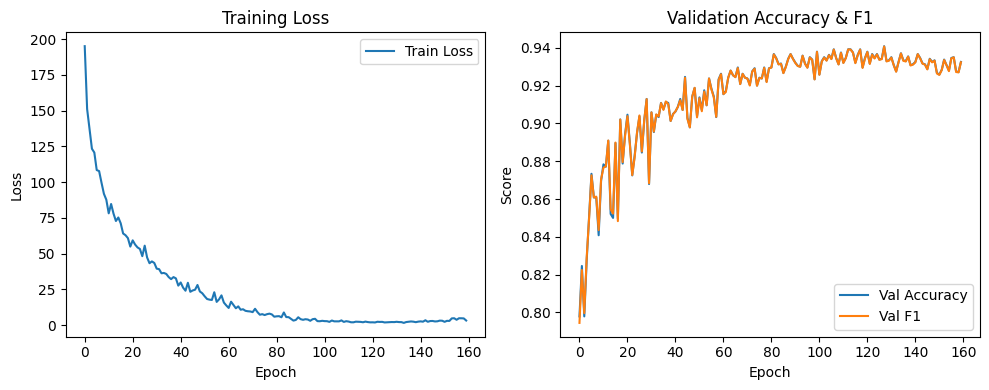

In [ ]:
# Import required libraries
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Initialize tracking
train_losses, val_accuracies, f1_scores = [], [], []
best_val_accuracy = 0
resume_path = "resnet50_160_model_checkpoint.pth"

# Optional: Resume previous training
# checkpoint = torch.load(resume_path)
# start_epoch = checkpoint['epoch']
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# train_losses = checkpoint['train_losses']
# val_accuracies = checkpoint['val_accuracies']
# f1_scores = checkpoint['f1_scores']
# num_epochs = 50

start_epoch = 0  # 0 if training from scratch
num_epochs = EPOCH

for epoch in range(start_epoch, num_epochs):
    print(f"Starting Epoch {epoch+1}......")
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += labels.size(0)

    train_accuracy = correct / total_samples
    train_losses.append(total_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    model.eval()
    val_correct = 0
    val_samples = 0
    true_labels = []
    pred_labels = []
    pred_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            val_correct += (preds == labels).sum().item()
            val_samples += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
            pred_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    val_accuracy = val_correct / val_samples
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    auc = roc_auc_score(true_labels, pred_probs, multi_class='ovr', average='weighted')

    val_accuracies.append(val_accuracy)
    f1_scores.append(f1)

    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print(f'Precision: {precision:.4f}, Recall (Sensitivity): {recall:.4f}, F1-score: {f1:.4f}, AUC: {auc:.4f}')

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "resnet50_160_model_best.pth")
        print("✅ Saved Best Model!")

    # Save checkpoint to resume later
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_losses': train_losses,
        'val_accuracies': val_accuracies,
        'f1_scores': f1_scores
    }, resume_path)

    scheduler.step()
    new_lr = scheduler.get_last_lr()

torch.save(model.state_dict(), "resnet50_160_model_final.pth")
print("✅ Training Completed! Final Model Saved.")

# 📈 Plot & Save metrics
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.plot(f1_scores, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Accuracy & F1")
plt.legend()

plt.tight_layout()
plt.savefig("training_metrics_plot.png")
plt.show()

### 📦 Test

✅ **Multiclass ROC-AUC Score:** 0.9920


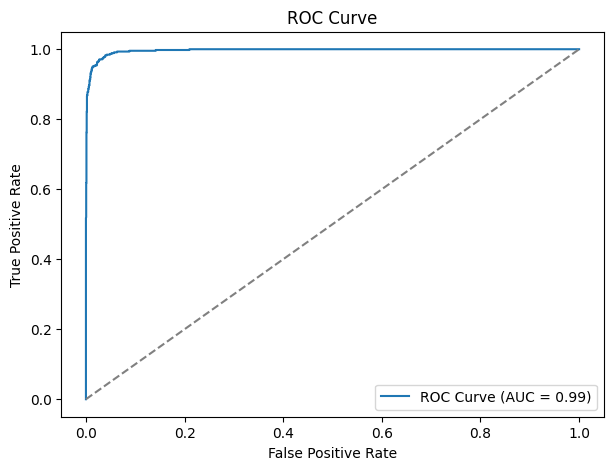

                        precision    recall  f1-score   support

                Benign       0.93      0.94      0.94      1050
   Intermediate-Benign       0.95      0.94      0.95       450
Intermediate-Malignant       0.95      0.97      0.96       150
             Malignant       0.92      0.90      0.91       750

              accuracy                           0.93      2400
             macro avg       0.94      0.94      0.94      2400
          weighted avg       0.93      0.93      0.93      2400



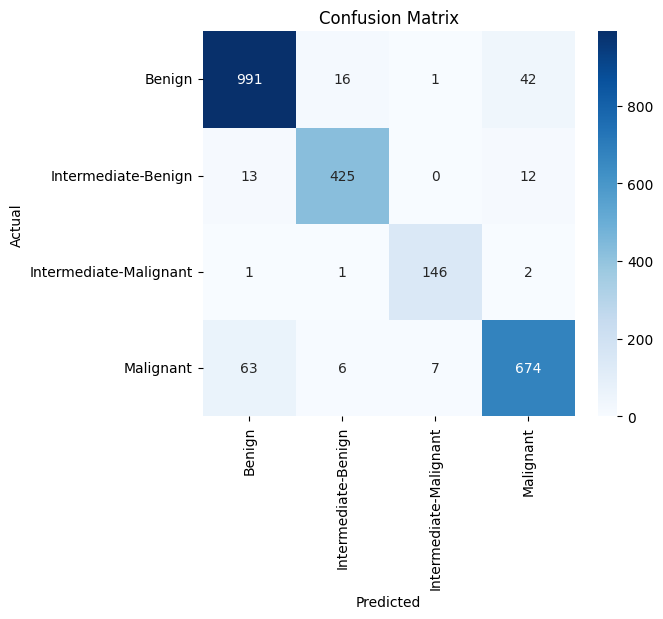

In [15]:
# Import required libraries
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Set model to evaluation mode
model.eval()
true_labels, pred_labels, pred_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

        pred_labels.extend(outputs.argmax(dim=1).cpu().numpy())  # Predicted class
        true_labels.extend(labels.cpu().numpy())  # True class
        pred_probs.extend(probs.cpu().numpy())  # Store all class probabilities

# Convert to NumPy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
pred_probs = np.array(pred_probs)  # Shape (num_samples, num_classes)

# Explicitly Binarize Labels for Multi-Class ROC-AUC
true_labels_bin = label_binarize(true_labels, classes=[0, 1, 2, 3])

# Compute Multi-Class ROC-AUC
roc_auc = roc_auc_score(true_labels_bin, pred_probs, multi_class='ovr')
print(f"✅ **Multiclass ROC-AUC Score:** {roc_auc:.4f}")

# Generate ROC Curve (For Class 1)
fpr, tpr, _ = roc_curve(true_labels_bin[:, 1], pred_probs[:, 1])
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.savefig('roc_curve.png')
plt.show()

# Classification Report
target_names = ['Benign', 'Intermediate-Benign', 'Intermediate-Malignant', 'Malignant']
print(classification_report(true_labels, pred_labels, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')
plt.show()